In [65]:
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.keras.backend.clear_session()

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:/Users/Sadiya Sajid/Downloads/waste_classification/garbage_classification",
    image_size=(224,224),
    batch_size=16,
    shuffle=True
)

class_names = dataset.class_names
num_classes = len(class_names)
print(class_names)


Found 15515 files belonging to 12 classes.
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [66]:
dataset_size = len(dataset)  # total number of images
train_size = int(0.8 * dataset_size)
val_size   = int(0.1 * dataset_size)
test_size  = dataset_size - train_size - val_size

train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size).take(val_size)
test_ds  = dataset.skip(train_size + val_size)


In [67]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [68]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [69]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.trainable = False


In [70]:
model = models.Sequential([
    data_augmentation,                    
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),                  
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])


In [71]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [72]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [74]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/5
776/776 [==============================] - 245s 302ms/step - loss: 0.9274 - accuracy: 0.7754 - val_loss: 0.5742 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 2/5
776/776 [==============================] - 232s 299ms/step - loss: 0.7004 - accuracy: 0.8412 - val_loss: 0.5369 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 3/5
776/776 [==============================] - 231s 298ms/step - loss: 0.6437 - accuracy: 0.8541 - val_loss: 0.4869 - val_accuracy: 0.9021 - lr: 0.0010
Epoch 4/5
776/776 [==============================] - 230s 296ms/step - loss: 0.6363 - accuracy: 0.8536 - val_loss: 0.4738 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 5/5
776/776 [==============================] - 232s 299ms/step - loss: 0.6271 - accuracy: 0.8586 - val_loss: 0.4658 - val_accuracy: 0.9098 - lr: 0.0010


In [75]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False


In [76]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [77]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
776/776 [==============================] - 302s 374ms/step - loss: 0.8368 - accuracy: 0.7950 - val_loss: 0.4167 - val_accuracy: 0.9227 - lr: 1.0000e-05
Epoch 2/10
776/776 [==============================] - 330s 425ms/step - loss: 0.6763 - accuracy: 0.8421 - val_loss: 0.4022 - val_accuracy: 0.9298 - lr: 1.0000e-05
Epoch 3/10
776/776 [==============================] - 639s 823ms/step - loss: 0.6217 - accuracy: 0.8569 - val_loss: 0.3963 - val_accuracy: 0.9311 - lr: 1.0000e-05
Epoch 4/10
776/776 [==============================] - 287s 370ms/step - loss: 0.5983 - accuracy: 0.8651 - val_loss: 0.3836 - val_accuracy: 0.9369 - lr: 1.0000e-05
Epoch 5/10
776/776 [==============================] - 284s 366ms/step - loss: 0.5712 - accuracy: 0.8767 - val_loss: 0.3851 - val_accuracy: 0.9362 - lr: 1.0000e-05
Epoch 6/10
776/776 [==============================] - 288s 371ms/step - loss: 0.5482 - accuracy: 0.8836 - val_loss: 0.3858 - val_accuracy: 0.9369 - lr: 1.0000e-05
Epoch 7/10
776/776 [==

In [78]:
scores=model.evaluate(test_ds)

97/97 [==============================] - 29s 179ms/step - loss: 0.3844 - accuracy: 0.9405


In [79]:
acc=history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss=history.history["loss"]
val_loss= history.history["val_loss"]


Image to prediction
Actual Label clothes
1/1 [==============================] - 0s 239ms/step
Predicted Label clothes


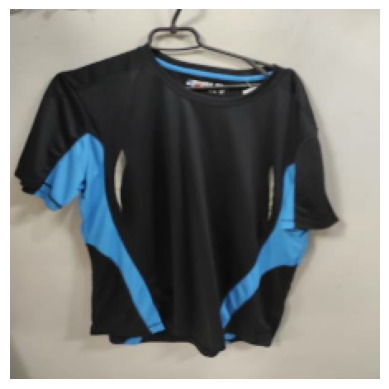

In [82]:
import numpy as np
for image_batch , label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("Image to prediction")
    plt.imshow(first_image)
    print("Actual Label",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")



In [94]:
def predict(model,image):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    prediction=model.predict(img_array)

    predicted_class=class_names[np.argmax(prediction[0])]
    confidence= round(100*(np.max(prediction[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 89ms/step


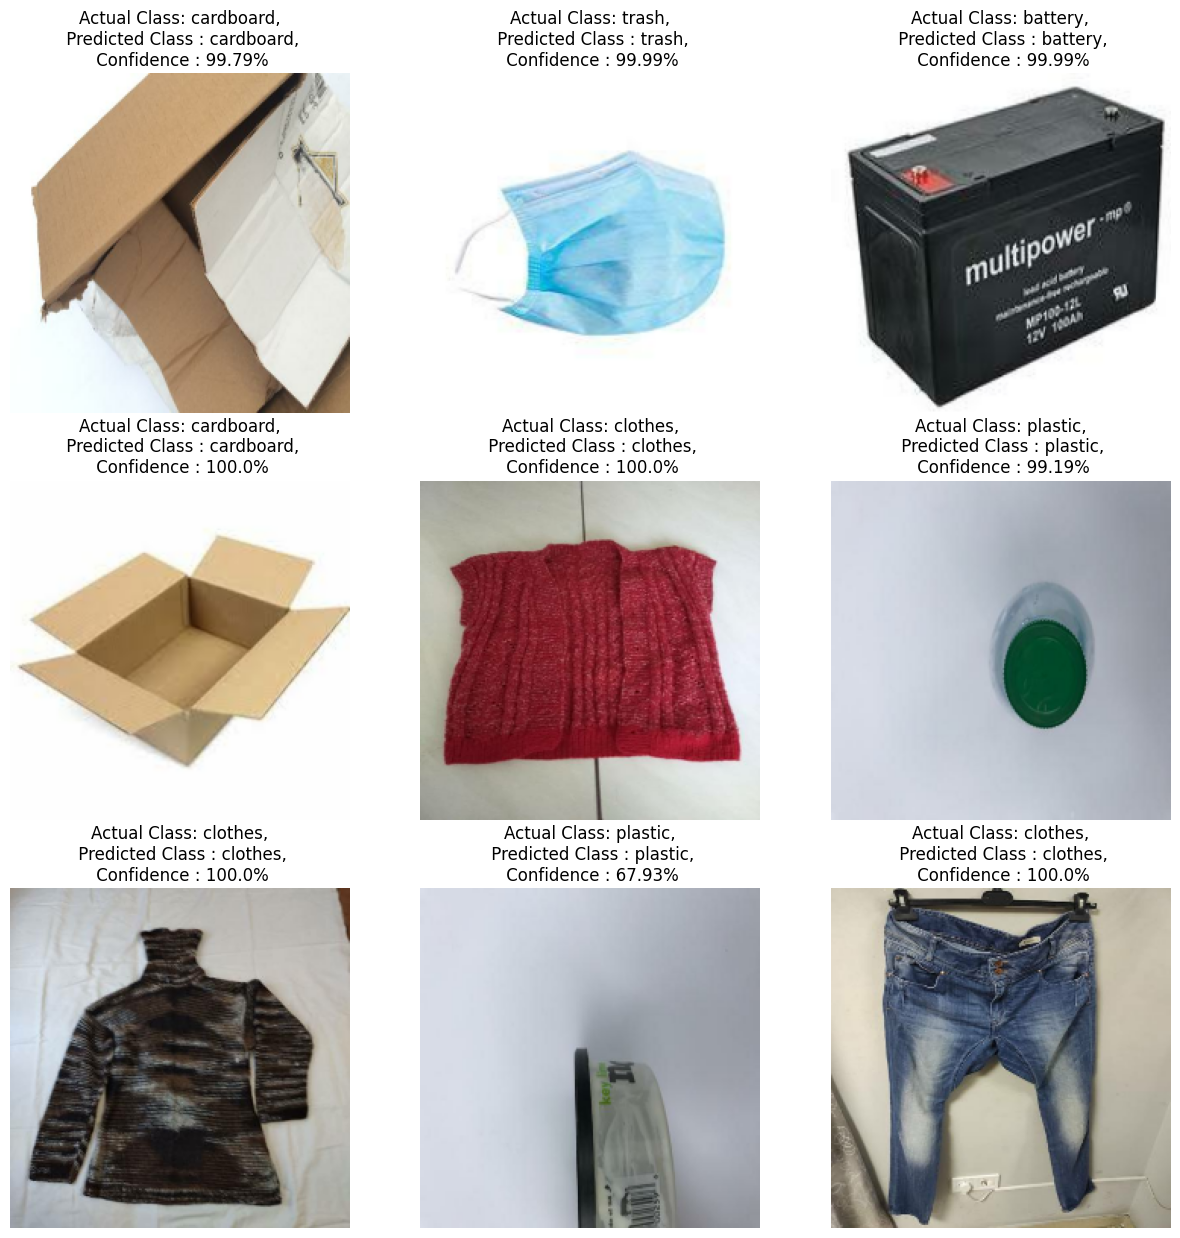

In [97]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual Class: {actual_class},\n Predicted Class : {predicted_class},\n Confidence : {confidence}%")
        plt.axis("off")
    

In [98]:
model_version=1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets
